# Ad-hoc Pulse Shape Simulation Using Cyclic Positional U-Net (CPU-Net)
- This is the source code of training and validating the performance of CPU-Net
- This code should run on a standard python environment with PyTorch installed.
    - we recommend installing a small gadget `tqdm` to monitor the time/progress of `for` loops. Installation can be done with `pip install tqdm --user`
    - If the user do not wish to install `tqdm`, please delete the import code and tdqm() wrapper
- This repository only contains the script of the model, training data has to be downloaded separately at [here](https://drive.google.com/file/d/1JcgQy6snavgcRetFAGl0QM3OAmPTqKqt/view?usp=sharing).
- Once downloaded, please unzip it and dump it into the same folder with this script

In [5]:
import os
import time
import random
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy import signal, sparse
from scipy.stats import norm
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.gridspec as gridspec
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torch.nn.parameter import Parameter
import torch.nn.functional as F
from torch import einsum

# Loading CPU-Net and support functions
from tools import (calc_current_amplitude, process_all_waveforms, calculate_tn, check_peak_alignment,
                   get_tail_slope, inf_train_gen, LambdaLR, weights_init_normal, select_quantile)
from dataset import SplinterDataset, SEQ_LEN, LSPAN, RSPAN
from network import PositionalUNet, RNN

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Running on", DEVICE)
torch.cuda.empty_cache()

Running on cuda:0


Below are the hyperparameters for model training, it is recommended to tune them for different detectors and operating conditions

In [6]:
BATCH_SIZE = 16 # batch size, each batch is drawn from the infinite train generator
baseline_weight=3.0 # weight given to baseline portion of the waveform in loss function
risingedge_weight=8.0 # weight giveing to rising edge of the waveform in loss function
tail_weight=7.0 # weight giving to the RC decay tail of the wavefrom in loss function
ITERS = 20000 # max number of interations to run
DECAY = 13200 # iteration at which learning rate starts to decay
LRATE_Gen =1e-3 # learning rate of the generator
LRATE_Disc =1e-3 # learning rate of the discriminator
cycle_loss_weight = 10 # weight of the cycle consistent loss in training, eg loss(sim->data->sim)
identity_loss_weight = 1 # weight of idenentity loss, for example ATN(data)- data
gan_loss_weight = 4 # weight of the generator loss. ATN(sim) - data
bin_check_iter = 13200 # iteration at which we start checking with validation dataset
bin_thres = 0 # toletance of matchig peaks of current amplitudes in validation, 0 means that peaks have to allign perfectly
print_interval = 1 # how often to check if the training and validation peaks allign

Our goal is to train on FEP peak which contains both multisite and single site events, and validate on DEP which is primaraly single site and SEP which is primaraliy multi site

In [7]:
eng_peak='fep' # training peak
det_pulses=f"/nas/longleaf/home/kbhimani/CPU-Net/training_data/{eng_peak}_wf_ornl.pickle"
sim_pulses=f"/nas/longleaf/home/kbhimani/ornl_sims/sim_wf_pkl/{eng_peak}_wf_sim.pickle"

## Load Dataset
- This function loads the siggen simulation and detector pulse dataset, splitting them into training and validation data loader
- Simulated pulses are generated in Siggen
- Detector pulses are collected from a local Ge detector

## U-Net Training
    - target_real: a vector of 1, used for GAN discriminator training
    - target_fake: a vector of 0, used for GAN discriminator training
    

- Create infinite train generator. This generator can be called an infinite amount of time to draw from training dataset (with repetition)

- Create network structures and feed them into the DEVICE defined above
    - A: Detector Pulses
    - B: Simulated Pulses
    - BtoA: Ad-hoc Translation Network (Simulation to Data)
    - AtoB: Inverse Ad-hoc Translation Network (Data to Simulation)

SplinterDataset class reads waveform data from pickle files, applies data cleaning cuts based on chi-squared and tail slope (tau) values, performs necessary waveform padding and normalization, and integrates with PyTorch's DataLoader for batch processing.
To skip the data cleaning cuts, set a really high value such as chi_squared_threshold=100, popt_threshold_under=-10, popt_threshold_over=10
Data laoder also outputs chi squared and taus values from the dataset which can then be used to set a cut

Chi squared cut is 0.004
Tail slope cut over is -0.000282
Tail slope cut under is -0.000304
10000 waveforms loaded from data.
20000 waveforms loaded from data.
30000 waveforms loaded from data.
40000 waveforms loaded from data.
50000 waveforms loaded from data.
60000 waveforms loaded from data.
70000 waveforms loaded from data.
80000 waveforms loaded from data.
90000 waveforms loaded from data.
100000 waveforms loaded from data.
Number of Data events: 109594
10000 waveforms loaded from simulations.
20000 waveforms loaded from simulations.
30000 waveforms loaded from simulations.
40000 waveforms loaded from simulations.
50000 waveforms loaded from simulations.
60000 waveforms loaded from simulations.
70000 waveforms loaded from simulations.
80000 waveforms loaded from simulations.
90000 waveforms loaded from simulations.
100000 waveforms loaded from simulations.
110000 waveforms loaded from simulations.
Number of Simulations events 110403


NameError: name 'data_utils' is not defined

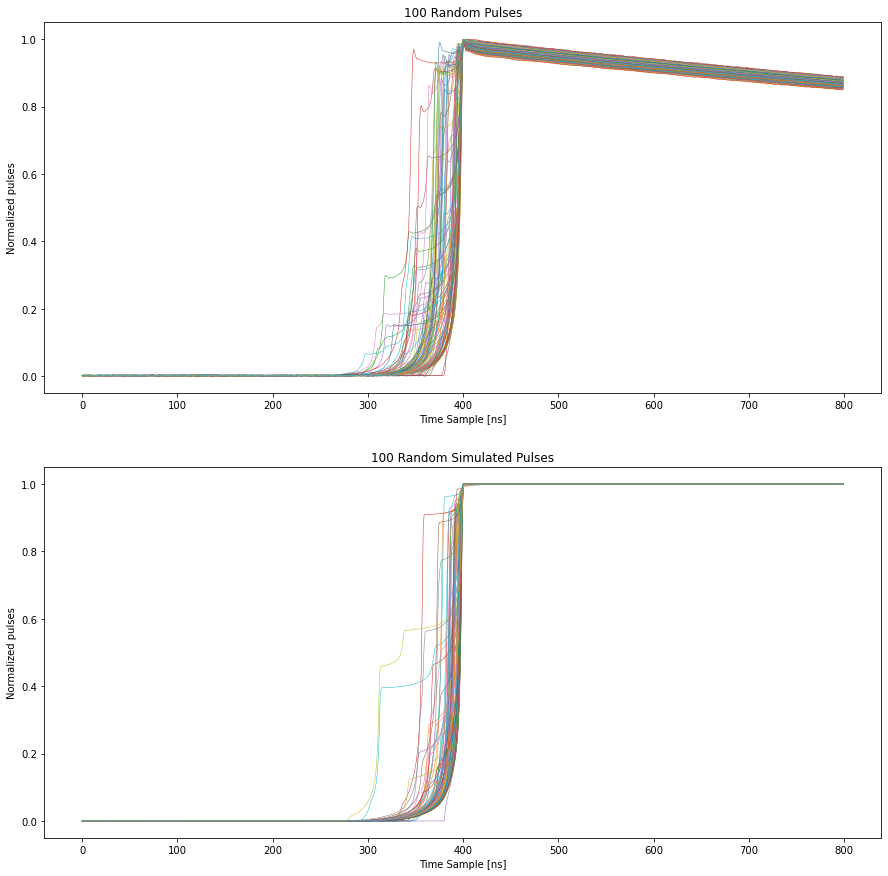

In [13]:
# This block load the FEP data for training
# dataset = SplinterDataset(det_pulses, sim_pulses,chi_squared_threshold=100, popt_threshold_under=-10, popt_threshold_over=10)
dataset = SplinterDataset(det_pulses, sim_pulses, n_max=1e6, chi_squared_threshold=0.004, popt_threshold_under=-3.04e-4, popt_threshold_over=-2.82e-4)
validation_split = 0.0
shuffle_dataset = True
random_seed= 42222
indices = np.arange(len(dataset))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
split = int(validation_split*len(dataset))
train_indices, val_indices = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)
dataset.set_raw_waveform(False)
train_loader = data_utils.DataLoader(dataset, batch_size=BATCH_SIZE, sampler=train_sampler,  drop_last=True)
test_loader = data_utils.DataLoader(dataset, batch_size=BATCH_SIZE, sampler=valid_sampler,  drop_last=True)
data = inf_train_gen(train_loader)

110295


Text(0.5, 1.0, 'Distribution of linear fit to -log Waveforms tail')

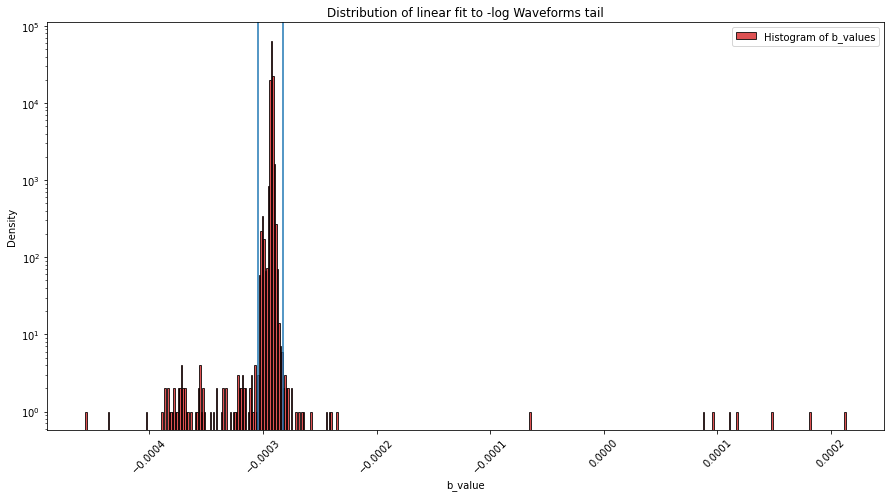

In [5]:
# An example to set cuts on Tau
# linear_b_values = dataset.tau_fits
linear_b_values = np.load('plot_data/linear_b_values.npy')

print(len(linear_b_values))
plt.figure(figsize=(15,7.5))
plt.hist(linear_b_values, bins=500, color='tab:red', label="Histogram of b_values",alpha=0.8, edgecolor='k')
plt.legend()
plt.xlabel('b_value')
plt.ylabel('Density')
plt.yscale('log')
plt.axvline(-2.82e-4)
plt.axvline(-3.04e-4)

plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability
plt.title('Distribution of linear fit to -log Waveforms tail')
# np.save('plot_data/linear_b_values.npy', dataset.tau_fits)
# plt.savefig("figs/chi_squared.png",dpi=200)


(array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 ]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

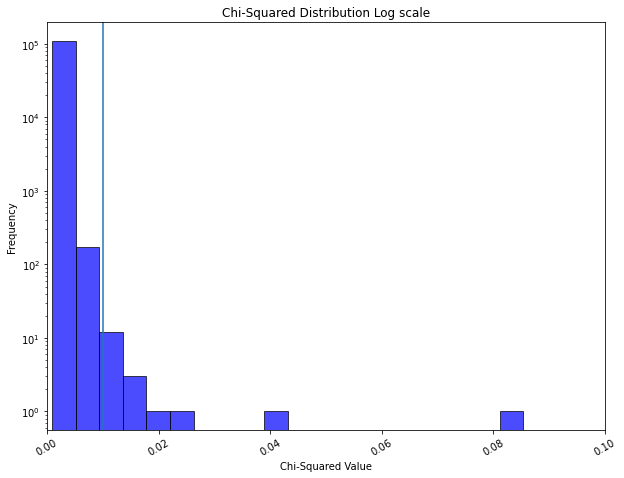

In [4]:
# An example to set chi squared cuts
plt.figure(figsize=(10,7.5))
# chi_squared = dataset.chi_squared_coeff
chi_squared = np.load('plot_data/chi_squared_coeff.npy')

plt.hist(chi_squared, bins=1000, color='b', alpha=0.7, edgecolor='k')
plt.xlim(0, 1e-1)
plt.title('Chi-Squared Distribution Log scale')
plt.xlabel('Chi-Squared Value')
plt.yscale('log')
plt.ylabel('Frequency')
plt.axvline(0.01)
plt.xticks(rotation=30)  # Rotate the x-axis labels for better readability
# np.save('plot_data/chi_squared_coeff.npy', dataset.chi_squared_coeff)

# plt.savefig("figs/chi_squared.png",dpi=200)

Chi squared cut is 0.004
Tail slope cut over is -0.000282
Tail slope cut under is -0.000304
0 waveforms loaded from data.
10000 waveforms loaded from data.
10000 waveforms loaded from data.
Number of Data events: 15392
10000 waveforms loaded from simulations.
Number of Simulations events 12701


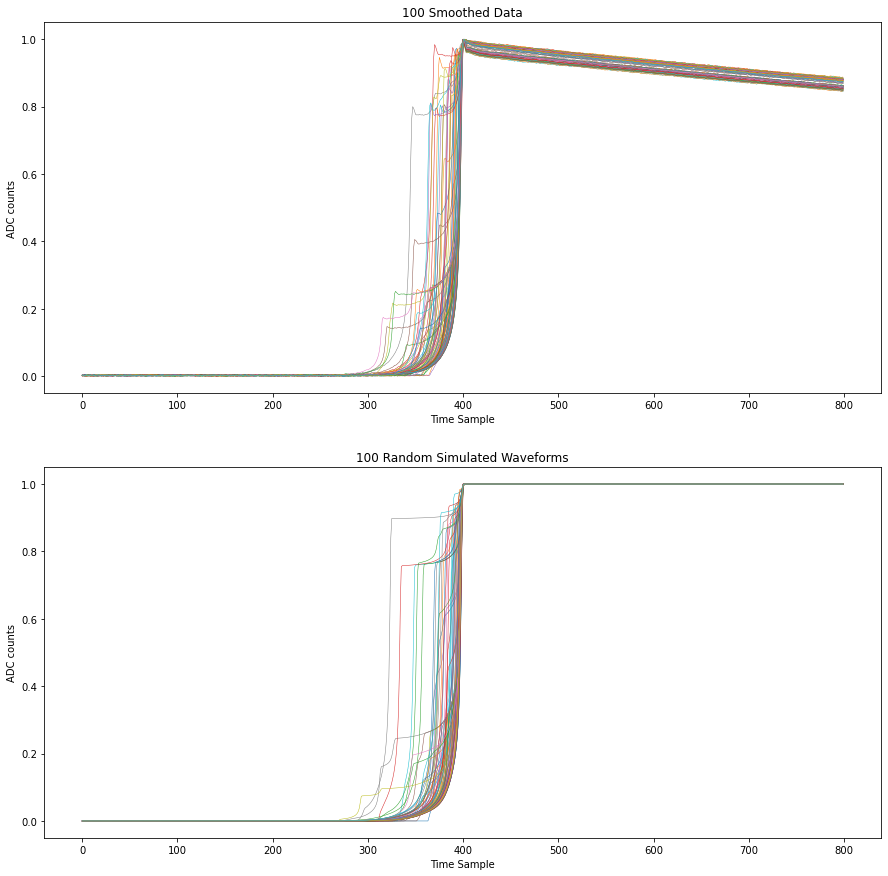

In [4]:
# This block loads the SEP data for validation
# dataset = SplinterDataset(det_pulses, sim_pulses,chi_squared_threshold=100, popt_threshold_under=-10, popt_threshold_over=10)
det_pulses_sep=f"/nas/longleaf/home/kbhimani/CPU-Net/training_data/sep_wf_ornl.pickle"
sim_pulses_sep=f"/nas/longleaf/home/kbhimani/ornl_sims/sim_wf_pkl/sep_wf_sim.pickle"
dataset_sep = SplinterDataset(det_pulses_sep, sim_pulses_sep, n_max=2e4, chi_squared_threshold=0.004, popt_threshold_under=-3.04e-4, popt_threshold_over=-2.82e-4)
validation_split = 0.0
shuffle_dataset = True
random_seed= 42222
indices = np.arange(len(dataset_sep))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
split = int(validation_split*len(dataset_sep))
train_indices, val_indices = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)
dataset_sep.set_raw_waveform(False)
train_loader_sep = data_utils.DataLoader(dataset_sep, batch_size=BATCH_SIZE, sampler=train_sampler,  drop_last=True)
test_loader_sep = data_utils.DataLoader(dataset_sep, batch_size=BATCH_SIZE, sampler=valid_sampler,  drop_last=True)
data_sep = inf_train_gen(train_loader_sep)

Chi squared cut is 0.004
Tail slope cut over is 0.000282
Tail slope cut under is -0.000304
0 waveforms loaded from data.
0 waveforms loaded from data.
Number of Data events: 3974
Number of Simulations events 2989


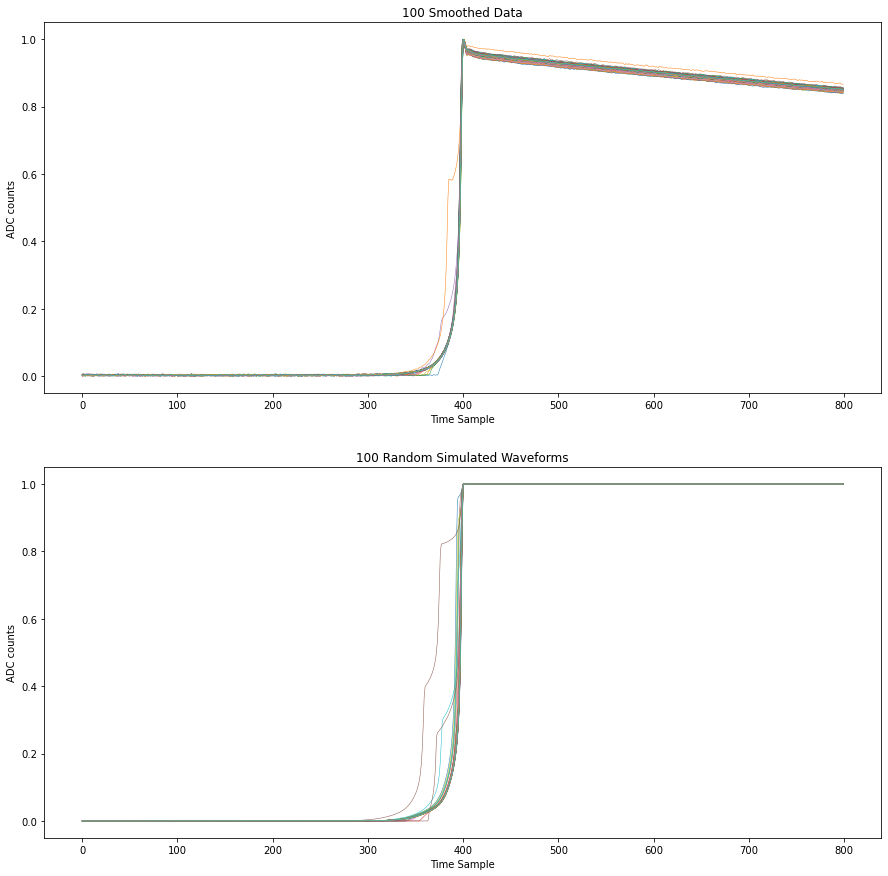

In [5]:
# This block loades the DEP dataset for validation
det_pulses_dep=f"/nas/longleaf/home/kbhimani/CPU-Net/training_data/dep_wf_ornl.pickle"
sim_pulses_dep=f"/nas/longleaf/home/kbhimani/ornl_sims/sim_wf_pkl/dep_wf_sim.pickle"
dataset_dep = SplinterDataset(det_pulses_dep, sim_pulses_dep, n_max=2e4, chi_squared_threshold=0.004, popt_threshold_under=-3.04e-4, popt_threshold_over=--2.82e-4)
validation_split = 0.0
shuffle_dataset = True
random_seed= 42222
indices = np.arange(len(dataset_dep))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
split = int(validation_split*len(dataset_dep))
train_indices, val_indices = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)
dataset_dep.set_raw_waveform(False)
train_loader_dep = data_utils.DataLoader(dataset_dep, batch_size=BATCH_SIZE, sampler=train_sampler,  drop_last=True)
test_loader_dep = data_utils.DataLoader(dataset_dep, batch_size=BATCH_SIZE, sampler=valid_sampler,  drop_last=True)
data_dep = inf_train_gen(train_loader_dep)

917


Text(0, 0.5, 'ADC counts')

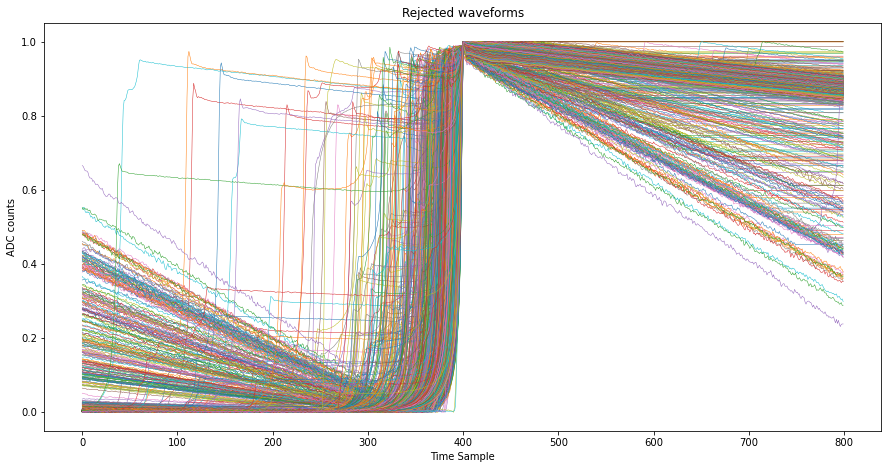

In [6]:
# Plots the rejected waveform from FEP training dataset
print(len(dataset.rejected_wf))
plt.figure(figsize=(15,7.5))
for i in range(len(dataset.rejected_wf)):
    waveform = dataset.rejected_wf[i]
    plt.plot(waveform,linewidth=0.5)
plt.title("Rejected waveforms")
plt.xlabel("Time Sample")
# plt.axhline(y=0.85)
plt.ylabel("ADC counts")

In [9]:
# Example code to fit tau values to a Gaussian if needed for Analysis
# import numpy as np
# import matplotlib.pyplot as plt
# from scipy.optimize import curve_fit
# # b_values = np.loadtxt('plot_data/b_values_sep_exp.txt')
# # b_values=-b_values
# # # cut= ((b_values>0.00034)&(b_values<0.00038))
# # b_values= b_values

# # 1. Define the Gaussian function
# def gaussian(x, amplitude, mean, stddev):
#     return amplitude * np.exp(-((x - mean) / stddev)**2 / 2)

# # If after removing non-finite values, b_values is empty, handle it accordingly
# if b_values.size == 0:
#     print("All values are non-finite. Cannot create histogram.")
# else:
#     # 2. Create a histogram
#     hist, bin_edges = np.histogram(b_values, bins=500)
#     bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

#     # 3. Fit the histogram to the Gaussian function
#     params, covariance = curve_fit(gaussian, bin_centers, hist, p0=[200, 0.0003, 6e-6], maxfev=200000)

#     # Plotting
#     plt.hist(b_values, bins=500, color='b', label="Histogram of b_values")
#     plt.plot(bin_centers, gaussian(bin_centers, *params), 'r-', label="Fitted Gaussian")
#     plt.legend()
#     plt.xlabel('b_value')
#     plt.ylabel('Density')
#     plt.xlim(2.5e-4, 4e-4)
#     plt.title('Distribution of exponential fit to Waveforms')

#     # Displaying the mean value
#     mean_text = f"Mean: {params[1]:.2e}"
#     plt.text(0.000356, max(hist)/2, mean_text, fontsize=12, color='red')

#     # plt.show()
#     print(f"Amplitude: {params[0]}, Mean: {params[1]}, Stddev: {params[2]}")
#     plt.savefig("figs/exp_fit.pdf",format="pdf",dpi=150)


- Create loss function and set up optimizer
    - BCELoss for discriminator
    - WFDist is a special L1loss where additional weight is added to the rising and falling edge of the waveform

In [10]:
class WFDist(nn.Module):
    '''
    Waveform Distance, this is a special type of L1 loss which gives more weight to the
    rising and falling edge of each pulse
    baseline(0,250) rising edge=(250,500), tail=(500,800)

    '''
    def __init__(self, baseline_weight, risingedge_weight, tail_weight):
        super(WFDist, self).__init__()
        self.criterion = nn.L1Loss()
        self.weight = torch.tensor([baseline_weight]*250+[risingedge_weight]*250+[tail_weight]*(300)).to(DEVICE)
        # self.weight = torch.tensor([3.0]*250+[8.0]*250+[6.0]*(300)).to(DEVICE) #latest to work

    def forward(self, x1, x2):
        loss_out = 0.0
        for i in range(x1.size(0)):
            loss_out += self.criterion(x1[i].view(-1)*self.weight, x2[i].view(-1)*self.weight)#/self.weight.sum()
        return loss_out/x1.size(0)

In [11]:
target_real = torch.ones(BATCH_SIZE,1).to(DEVICE) #tensor to hold 
target_fake = torch.zeros(BATCH_SIZE,1).to(DEVICE)
netG_A2B = PositionalUNet() # Generator from Data to Simulations (ATN)
netG_B2A = PositionalUNet() # Generator from Simulations to Data (IATN)
netD_A = RNN().apply(weights_init_normal) # Discriminator whose job is to verigy is a pulse looks like data
netD_B = RNN().apply(weights_init_normal) # Discriminator whose job is to verigy is a pulse looks like simulations
netG_A2B.to(DEVICE)
netG_B2A.to(DEVICE)
netD_A.to(DEVICE)
netD_B.to(DEVICE)

criterion_GAN = nn.BCELoss().to(DEVICE)
criterion_cycle = WFDist(baseline_weight, risingedge_weight, tail_weight).to(DEVICE)
criterion_identity = WFDist(baseline_weight, risingedge_weight, tail_weight).to(DEVICE)

optimizer_G = torch.optim.Adam(itertools.chain(netG_A2B.parameters(), netG_B2A.parameters()), lr=LRATE_Gen, betas=(0.5, 0.999))
optimizer_D_A = torch.optim.Adam(netD_A.parameters(), lr=LRATE_Disc, betas=(0.5, 0.999))
optimizer_D_B = torch.optim.Adam(netD_B.parameters(), lr=LRATE_Disc, betas=(0.5, 0.999))


lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(optimizer_G, lr_lambda=LambdaLR(ITERS, 0, DECAY).step)
lr_scheduler_D_A = torch.optim.lr_scheduler.LambdaLR(optimizer_D_A, lr_lambda=LambdaLR(ITERS, 0, DECAY).step)
lr_scheduler_D_B = torch.optim.lr_scheduler.LambdaLR(optimizer_D_B, lr_lambda=LambdaLR(ITERS, 0, DECAY).step)


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total trainable parameters in netG_A2B: {count_parameters(netG_A2B)}")
print(f"Total trainable parameters in netG_B2A: {count_parameters(netG_B2A)}")
print(f"Total trainable parameters in netD_A: {count_parameters(netD_A)}")
print(f"Total trainable parameters in netD_B: {count_parameters(netD_B)}")

Total trainable parameters in netG_A2B: 7213781
Total trainable parameters in netG_B2A: 7213781
Total trainable parameters in netD_A: 130817
Total trainable parameters in netD_B: 130817


- Start training

In [13]:
# Initialize lists to store loss values
losses_G = []
losses_D_A = []
losses_D_B = []
losses_GAN_A2B =[]
losses_GAN_B2A =[]
losses_identity_A = []
losses_identity_B = []
losses_cycle_ABA = []
losses_cycle_BAB = []
learning_rates_G = []
 
for iteration in tqdm(range(ITERS)):
    netG_A2B.train()
    netG_B2A.train()

    #########################
    # A: det_pulsesrPulses
    # B: Simulated Pulses
    #########################
    
    real_A, real_B = next(data)
    real_A = real_A.to(DEVICE).float()
    real_B = real_B.to(DEVICE).float()

    ###### Generators A2B and B2A ######
    optimizer_G.zero_grad()

    # Identity loss
    # G_A2B(B) should equal B if real B is fed
    same_B = netG_A2B(real_B)
    loss_identity_B = criterion_identity(same_B, real_B)*identity_loss_weight
    # G_B2A(A) should equal A if real A is fed
    same_A = netG_B2A(real_A)
    loss_identity_A = criterion_identity(same_A, real_A)*identity_loss_weight

    # GAN loss
    fake_B = netG_A2B(real_A)
    pred_fake = netD_B(fake_B)
    # loss_GAN_A2B = pred_fake.mean()
    # loss_GAN_A2B.backward(target_real)
    loss_GAN_A2B = criterion_GAN(pred_fake, target_real)*gan_loss_weight

    fake_A = netG_B2A(real_B)
    pred_fake = netD_A(fake_A)
    # loss_GAN_B2A = pred_fake.mean()
    # rand = torch.tensor(np.random.rand()).to(DEVICE)*0.5+0.5
    # random_real = random_real[torch.randperm(random_real.size(0))]
    loss_GAN_B2A = criterion_GAN(pred_fake,target_real)*gan_loss_weight

    # Cycle loss
    recovered_A = netG_B2A(fake_B)
    loss_cycle_ABA = criterion_cycle(recovered_A, real_A)*cycle_loss_weight

    recovered_B = netG_A2B(fake_A)
    loss_cycle_BAB = criterion_cycle(recovered_B, real_B)*cycle_loss_weight

    # Total loss
    loss_G = loss_identity_A + loss_identity_B + loss_cycle_ABA + loss_cycle_BAB + loss_GAN_A2B + loss_GAN_B2A
    loss_G.backward()

    optimizer_G.step()
    ###### Discriminator A (Detector Pulses) ######
    optimizer_D_A.zero_grad()

    # Real loss
    pred_real = netD_A(real_A)
    loss_D_real = criterion_GAN(pred_real, target_real)

    # Fake loss
    pred_fake = netD_A(fake_A.detach())
    loss_D_fake = criterion_GAN(pred_fake, target_fake)


    # Total loss
    loss_D_A = loss_D_real + loss_D_fake
    loss_D_A.backward()

    optimizer_D_A.step()
    ###### Discriminator B (Simulated Pulses) ######
    optimizer_D_B.zero_grad()

    # Real loss
    pred_real = netD_B(real_B)
    loss_D_real = criterion_GAN(pred_real, target_real)

    # Fake loss
    pred_fake = netD_B(fake_B.detach())
    loss_D_fake = criterion_GAN(pred_fake, target_fake)

    # Total loss
    loss_D_B = loss_D_real + loss_D_fake
    loss_D_B.backward()
    optimizer_D_B.step()

    current_lr_G = lr_scheduler_G.get_last_lr()[0]
    # Append each loss to its corresponding list
    losses_G.append(loss_G.item())
    losses_D_A.append(loss_D_A.item())
    losses_D_B.append(loss_D_B.item())
    losses_GAN_A2B.append(loss_GAN_A2B.item())
    losses_GAN_B2A.append(loss_GAN_B2A.item())
    losses_identity_A.append(loss_identity_A.item())
    losses_identity_B.append(loss_identity_B.item())
    losses_cycle_ABA.append(loss_cycle_ABA.item())
    losses_cycle_BAB.append(loss_cycle_BAB.item())
    learning_rates_G.append(current_lr_G)

    lr_scheduler_G.step()
    lr_scheduler_D_A.step()
    lr_scheduler_D_B.step()

    # Print average losses every 'print_interval' iterations
    if (iteration + 1) % print_interval == 0:
        if iteration> bin_check_iter-1:
            # Access the current learning rate
            # Print losses and current learning rate
            current_lr_D_A = lr_scheduler_D_A.get_last_lr()[0]
            current_lr_D_B = lr_scheduler_D_B.get_last_lr()[0]
            # print(f"Iteration {iteration + 1}/{ITERS}")
            # print(f"  Avg Generator Loss: {sum(losses_G[-print_interval:]) / print_interval:.4f}")
            # print(f"  Avg Discriminator A Loss: {sum(losses_D_A[-print_interval:]) / print_interval:.4f}")
            # print(f"  Avg Discriminator B Loss: {sum(losses_D_B[-print_interval:]) / print_interval:.4f}")
            # print(f"  Avg GAN A2B Loss: {sum(losses_GAN_A2B[-print_interval:]) / print_interval:.4f}")
            # print(f"  Avg GAN B2A Loss: {sum(losses_GAN_B2A[-print_interval:]) / print_interval:.4f}")
            # print(f"  Avg Identity A Loss: {sum(losses_identity_A[-print_interval:]) / print_interval:.4f}")
            # print(f"  Avg Identity B Loss: {sum(losses_identity_B[-print_interval:]) / print_interval:.4f}")
            # print(f"  Avg Cycle ABA Loss: {sum(losses_cycle_ABA[-print_interval:]) / print_interval:.4f}")
            # print(f"  Avg Cycle BAB Loss: {sum(losses_cycle_BAB[-print_interval:]) / print_interval:.4f}")
            # print(f"  Current LR for G: {current_lr_G:.5f}")
            # print(f"  Current LR for D_A: {current_lr_D_A:.5f}")
            # print(f"  Current LR for D_B: {current_lr_D_B:.5f}")
            
            netG_B2A.eval()  # Set the network to evaluation mode
            sep_alignment, peak_location_ca_sep, peak_location_gan_ca_sep = check_peak_alignment(train_loader_sep, netG_B2A, bin_thres)
            dep_alignment, peak_location_ca_dep, peak_location_gan_ca_dep = check_peak_alignment(train_loader_dep, netG_B2A, bin_thres)
            print(f"SEP Peak location for ca: {peak_location_ca_sep:.7f}, gan_ca: {peak_location_gan_ca_sep:.7f}")
            print(f"DEP Peak location for ca: {peak_location_ca_dep:.7f}, gan_ca: {peak_location_gan_ca_dep:.7f}")
            netG_B2A.train()  # Set the network back to training mode    
            if sep_alignment and dep_alignment:
                print(f"Stopping training at iteration {iteration + 1}: Peak bins match for both SEP and DEP within tolerance.")
                torch.save(netG_B2A.state_dict(), f'model_weights/{eng_peak}_ATN.pt')
                torch.save(netG_A2B.state_dict(), f'model_weights/{eng_peak}_IATN.pt')  
                torch.save(netD_A.state_dict(), f'model_weights/{eng_peak}_netD_A.pth')
                torch.save(netD_B.state_dict(), f'model_weights/{eng_peak}_netD_B.pth')
                np.save("plot_data/losses_G.npy", np.array(losses_G))
                np.save("plot_data/losses_D_A.npy", np.array(losses_D_A))
                np.save("plot_data/losses_D_B.npy", np.array(losses_D_B))
                np.save("plot_data/losses_GAN_A2B.npy", np.array(losses_GAN_A2B))
                np.save("plot_data/losses_GAN_B2A.npy", np.array(losses_GAN_B2A))
                np.save("plot_data/losses_identity_A.npy", np.array(losses_identity_A))
                np.save("plot_data/losses_identity_B.npy", np.array(losses_identity_B))
                np.save("plot_data/losses_cycle_ABA.npy", np.array(losses_cycle_ABA))
                np.save("plot_data/losses_cycle_BAB.npy", np.array(losses_cycle_BAB))
                np.save("plot_data/learning_rates_G.npy", np.array(learning_rates_G))
                break  # Stop training

 66%|██████▌   | 13201/20000 [43:38<1:02:48,  1.80it/s]

SEP Peak location for ca: 0.0001017, gan_ca: 0.0001061
DEP Peak location for ca: 0.0001330, gan_ca: 0.0001365


 66%|██████▌   | 13202/20000 [43:39<1:30:30,  1.25it/s]

SEP Peak location for ca: 0.0001017, gan_ca: 0.0001043
DEP Peak location for ca: 0.0001330, gan_ca: 0.0001348


 66%|██████▌   | 13203/20000 [43:41<1:50:41,  1.02it/s]

SEP Peak location for ca: 0.0001017, gan_ca: 0.0001043
DEP Peak location for ca: 0.0001330, gan_ca: 0.0001330


 66%|██████▌   | 13204/20000 [43:42<2:04:04,  1.10s/it]

SEP Peak location for ca: 0.0001017, gan_ca: 0.0001026
DEP Peak location for ca: 0.0001330, gan_ca: 0.0001330


 66%|██████▌   | 13205/20000 [43:44<2:13:18,  1.18s/it]

SEP Peak location for ca: 0.0001017, gan_ca: 0.0001035
DEP Peak location for ca: 0.0001330, gan_ca: 0.0001330
SEP Peak location for ca: 0.0001017, gan_ca: 0.0001017
DEP Peak location for ca: 0.0001330, gan_ca: 0.0001330
Stopping training at iteration 13206: Peak bins match for both SEP and DEP within tolerance.


 66%|██████▌   | 13205/20000 [43:45<22:31,  5.03it/s]  


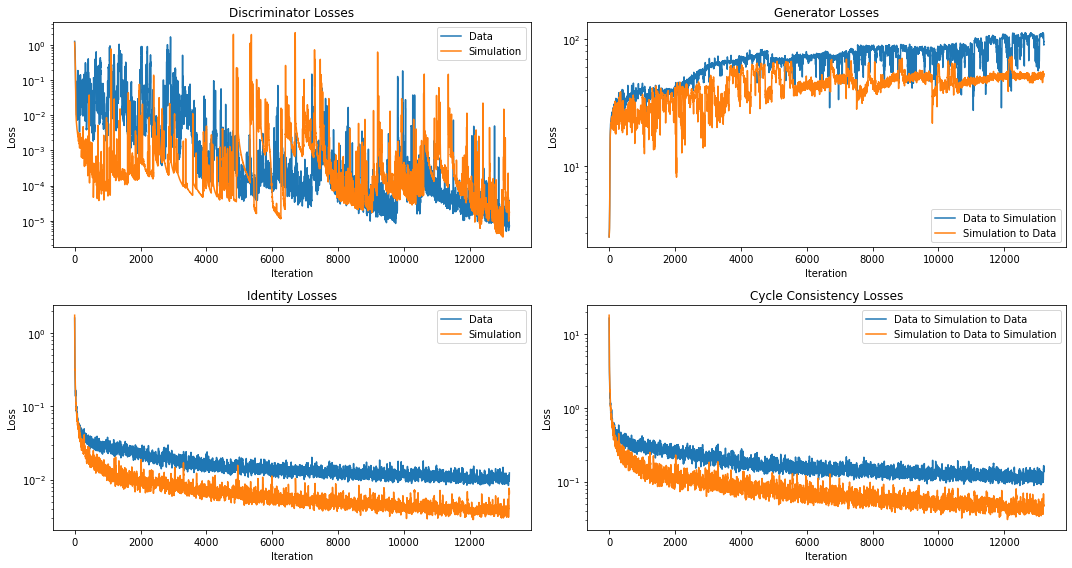

In [5]:
import numpy as np
import matplotlib.pyplot as plt
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w
win=5 
losses_G = np.load("plot_data/losses_G.npy")
losses_D_A = np.load("plot_data/losses_D_A.npy")
losses_D_B = np.load("plot_data/losses_D_B.npy")
losses_GAN_A2B = np.load("plot_data/losses_GAN_A2B.npy")
losses_GAN_B2A = np.load("plot_data/losses_GAN_B2A.npy")
losses_identity_A = np.load("plot_data/losses_identity_A.npy")
losses_identity_B = np.load("plot_data/losses_identity_B.npy")
losses_cycle_ABA = np.load("plot_data/losses_cycle_ABA.npy")
losses_cycle_BAB = np.load("plot_data/losses_cycle_BAB.npy")

plt.figure(figsize=(15, 8))

plt.subplot(2, 2, 1)
# plt.plot(moving_average(losses_G, win), label='Total Generator Loss')
plt.plot(moving_average(losses_D_A, win), label='Data')
plt.plot(moving_average(losses_D_B, win), label='Simulation')
plt.title('Discriminator Losses')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.yscale('log')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(moving_average(losses_GAN_A2B, win), label='Data to Simulation')
plt.plot(moving_average(losses_GAN_B2A, win), label='Simulation to Data')
plt.title('Generator Losses')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.yscale('log')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(moving_average(losses_identity_A, win), label='Data')
plt.plot(moving_average(losses_identity_B, win), label='Simulation')
plt.title('Identity Losses')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.yscale('log')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(moving_average(losses_cycle_ABA, win), label='Data to Simulation to Data')
plt.plot(moving_average(losses_cycle_BAB, win), label='Simulation to Data to Simulation')
plt.title('Cycle Consistency Losses')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.yscale('log')
plt.legend()

plt.tight_layout()
# plt.savefig('figs/loss_funcs.png')

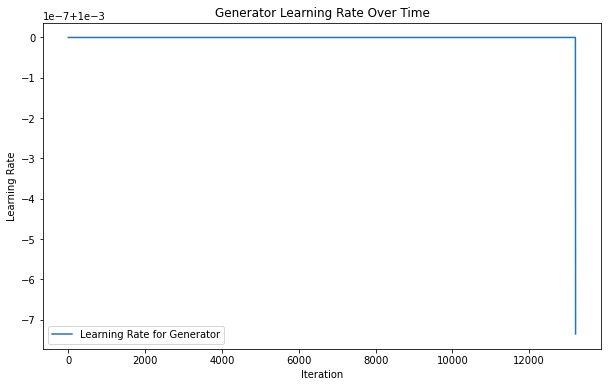

In [2]:
learning_rates_G = np.load("plot_data/learning_rates_G.npy")
plt.figure(figsize=(10, 6))
plt.plot(learning_rates_G, label='Learning Rate for Generator')
plt.xlabel('Iteration')
plt.ylabel('Learning Rate')
plt.title('Generator Learning Rate Over Time')
plt.legend()

- Save trloss_disN and IATN

# Performance Validation and Plot
- Load the trained ATN into the device, the code run the model through training data, just how well it is translating the pulses
- See the Analysis notebook for validation on SEP and DEP

In [9]:
ATN = PositionalUNet()
ATN.to(DEVICE)
pretrained_dict = torch.load(f'model_weights/{eng_peak}_ATN.pt')
# pretrained_dict = torch.load('fep_training/ATN_epoch_1.pt')
model_dict = ATN.state_dict()
model_dict.update(pretrained_dict) 
ATN.load_state_dict(pretrained_dict)
ATN.eval()

IATN = PositionalUNet()
IATN.to(DEVICE)
pretrained_dict_inv = torch.load(f'model_weights/{eng_peak}_IATN.pt')
# pretrained_dict = torch.load('fep_training/ATN_epoch_1.pt')

model_dict_inv = IATN.state_dict()
model_dict_inv.update(pretrained_dict_inv) 
IATN.load_state_dict(pretrained_dict_inv)
IATN.eval()
data_dict_loader = train_loader

NameError: name 'train_loader' is not defined

- Read a single batch from the test loader, translating it through the ATN

In [10]:
wf, wf_deconv, a,b = next(iter(data_dict_loader))
wf = wf.to(DEVICE)
wf_deconv = wf_deconv.to(DEVICE)
outputs  = ATN(wf_deconv)
outputs_inv = IATN(outputs)
iwf = 2 # the ith waveform in the batch to plot
detector_pulse = wf[iwf,0,:].cpu().data.numpy().flatten()
simulated_pulse = wf_deconv[iwf,0,:].cpu().data.numpy().flatten()
translated_pulse = outputs[iwf,0,:].cpu().data.numpy().flatten()
translated_pulse_inv = outputs_inv[iwf,0,:].cpu().data.numpy().flatten()

NameError: name 'data_dict_loader' is not defined

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def visualize_attention_weights_for_both(model_A, model_B, weights_path_A, weights_path_B, test_loader, device):
    # Load the saved weights for both models
    model_A.load_state_dict(torch.load(weights_path_A, map_location=device))
    model_B.load_state_dict(torch.load(weights_path_B, map_location=device))
    
    # Set both models to evaluation mode
    model_A.eval()
    model_B.eval()
    
    # Get a single batch from the test loader
    real_A, real_B, a, b = next(iter(test_loader))
    
    # Assume real_A and real_B are already on the correct device and normalized if necessary
    real_A = real_A.to(device)
    real_B = real_B.to(device)

    # Get the attention weights for the single input instance from both models
    with torch.no_grad():
        attention_weights_A = model_A.get_attention_weights(real_A).cpu().numpy()[0]  # Assuming a method that returns attention weights
        attention_weights_B = model_B.get_attention_weights(real_B).cpu().numpy()[0]  # Assuming a method that returns attention weights

    # Define time intervals for color coding (if applicable to your data)
    # Adjust according to your waveform length and relevant intervals
    time_intervals = [(0, 201, 'tab:blue'), (200, 451, 'tab:red'), (451, 800, 'tab:green')]
    detector_pulses= real_A[0].cpu().numpy()[0]
    simulated_pulses=real_B[0].cpu().numpy()[0]
    # Create figure for visualization
    fig, axs = plt.subplots(2, 2, figsize=(20, 10))  # Two rows for waveforms and attention, two columns for each model
    
    # Plot waveform and attention weights for model A (Detector Pulses)
    for start, end, color in time_intervals:
        axs[0, 0].plot(np.arange(start, min(end, len(detector_pulses))), detector_pulses[start:end], color=color, label=f'{start}-{end} ns')
    axs[0, 0].set_title('Detector Pulses')
    axs[0, 0].legend()

    axs[1, 0].plot(attention_weights_A, label='Attention Weights A')
    axs[1, 0].set_title('Attention Weights (Detector Pulses)')
    axs[1, 0].legend()

    # Plot waveform and attention weights for model B (Simulated Pulses)
    for start, end, color in time_intervals:
        axs[0, 1].plot(np.arange(start, min(end, len(simulated_pulses))), simulated_pulses[start:end], color=color, label=f'{start}-{end} ns') 
    axs[0, 1].set_title('Simulated Pulses')
    axs[0, 1].legend()

    axs[1, 1].plot(attention_weights_B, label='Attention Weights B')
    axs[1, 1].set_title('Attention Weights (Simulated Pulses)')
    axs[1, 1].legend()
    
    # Adjust layout and display the plot
    plt.tight_layout()
    plt.savefig("figs/attention_wf_plot_both.pdf", dpi=200)
    plt.show()
    
# Assuming netD_A and netD_B are instances of your model classes with attention mechanism
# And assuming the paths to their saved weights are correctly specified
netD_A = RNN(get_attention=True)  # Make sure to enable the get_attention flag
netD_B = RNN(get_attention=True)  # Make sure to enable the get_attention flag
weights_path_A = f'model_weights/{eng_peak}_netD_A.pth'
weights_path_B = f'model_weights/{eng_peak}_netD_B.pth'

# Now call the function to visualize the attention weights for both models
visualize_attention_weights_for_both(netD_A, netD_B, weights_path_A, weights_path_B, train_loader,'cpu')

NameError: name 'train_loader' is not defined

In [12]:
import matplotlib.pyplot as plt
import numpy as np

def plot_cycle_BAB_with_style(netG_A2B, netG_B2A, train_loader, DEVICE, sample_rate=5, eng_peak="eng_peak", eng_peak_load="eng_peak_load"):
    # Initialize lists to store waveforms
    real_Bs, fake_As, recovered_Bs, real_As = [], [], [], []

    time = np.linspace(0, 799, 800)
    cut = time > 0  # Assuming you're interested in the whole range

    # Loop over a fixed number of samples
    for _ in range(sample_rate):
        real_A, real_B, a, b = next(iter(train_loader))
        real_A = real_A.to(DEVICE)
        real_B = real_B.to(DEVICE)

        # Generate and recover
        with torch.no_grad():
            fake_A = netG_B2A(real_B)
            recovered_B = netG_A2B(fake_A)

        # Collect waveforms
        real_Bs.append(real_B[0, 0, :].cpu().numpy())
        fake_As.append(fake_A[0, 0, :].cpu().numpy())
        recovered_Bs.append(recovered_B[0, 0, :].cpu().numpy())
        real_As.append(real_A[0, 0, :].cpu().numpy())

    # Plotting
    colors = {
        "real_B": "#0072BD",  # bright blue
        "fake_A": "#D95319",  # bright orange
        "recovered_B": "#7E2F8E",  # purple
        "real_A": "#d62728",  # bricked red
    }

    fig, axs = plt.subplots(2, 2, figsize=(15, 15))  # Adjust the figure size as needed
    # Unpack the axes array and plot in each subplot
    ax1, ax2, ax3, ax4 = axs.flatten()
    for i in range(sample_rate):
        ax1.plot(time[cut], real_Bs[i][cut], color=colors["real_B"], label="Simulated Pulse" if i == 0 else "")
        ax2.plot(time[cut], fake_As[i][cut], color=colors["fake_A"], label="Translated Pulse" if i == 0 else "")
        ax3.plot(time[cut], recovered_Bs[i][cut], color=colors["recovered_B"], label="Recovered Pulse" if i == 0 else "")
        ax4.plot(time[cut], real_As[i][cut], color=colors["real_A"], label="Detector Pulse" if i == 0 else "")
    # Set common labels and adjust layout for clarity
    for ax in axs.flatten():
        ax.set_xlabel('Time (ns)')
        ax.set_ylabel('Amplitude')
        ax.legend(loc='lower right')
        # ax.grid(True)  # Add grid for better readability

    fig.tight_layout()  # Adjust subplots to fit into the figure area.
    # plt.suptitle(f"{eng_peak} events on {eng_peak_load} trained data", fontsize=16)
    plt.savefig("figs/result_comp_2x2_cycle_BAB.png")
    plt.show()

# Assuming netG_A2B, netG_B2A, DEVICE, and train_loader are already defined
plot_cycle_BAB_with_style(IATN, ATN, train_loader, DEVICE, sample_rate=5, eng_peak="YourEngPeak", eng_peak_load="YourEngPeakLoad")


NameError: name 'train_loader' is not defined

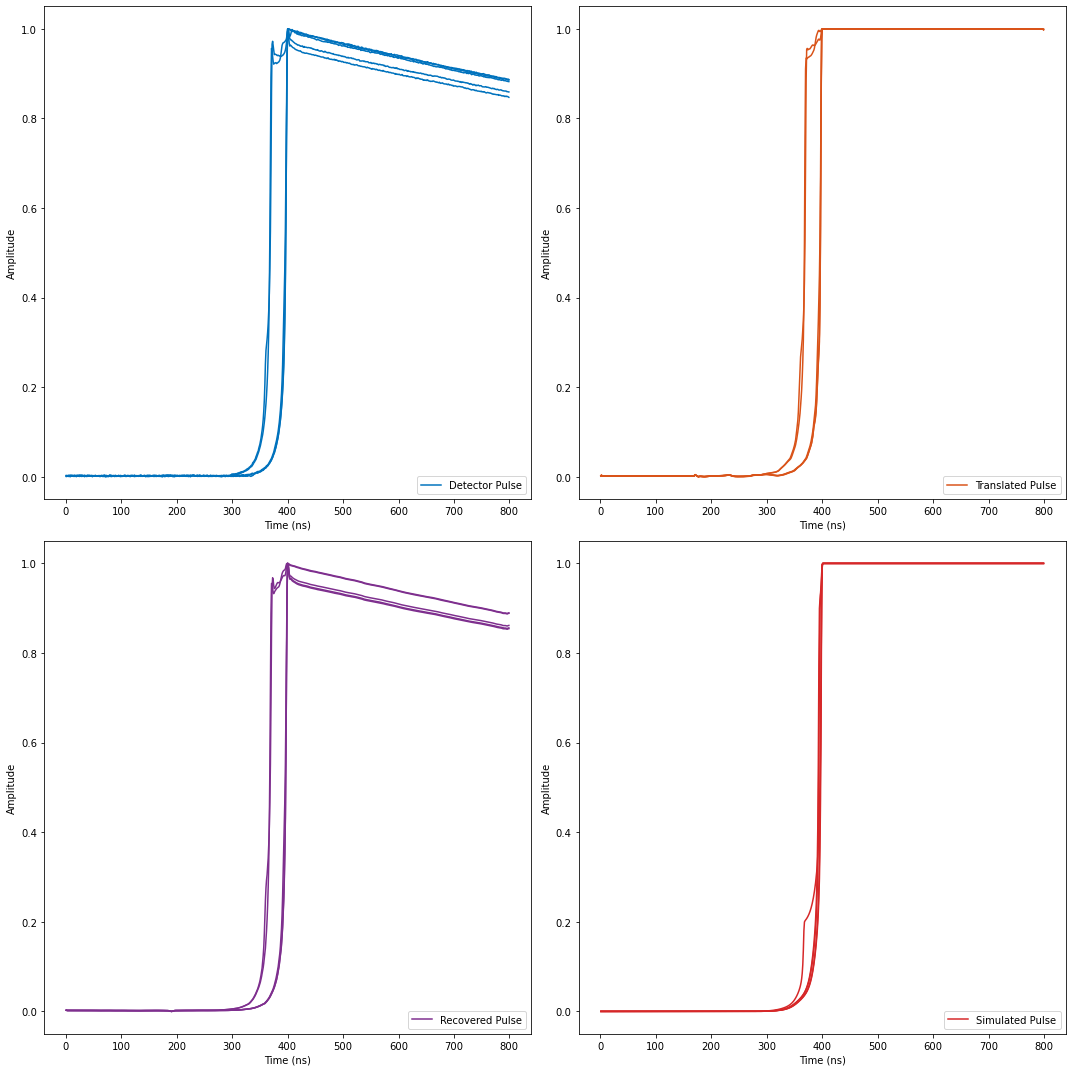

In [8]:
import matplotlib.pyplot as plt
import numpy as np

def plot_cycle_ABA_with_style(netG_A2B, netG_B2A, train_loader, DEVICE, sample_rate=5, eng_peak="eng_peak", eng_peak_load="eng_peak_load"):
    # Initialize lists to store waveforms
    real_As, fake_Bs, recovered_As, real_Bs = [], [], [], []

    time = np.linspace(0, 799, 800)
    cut = time > 0  # Assuming you're interested in the whole range

    # Loop over a fixed number of samples
    for _ in range(sample_rate):
        real_A, real_B, a, b = next(iter(train_loader))
        real_A = real_A.to(DEVICE)
        real_B = real_B.to(DEVICE)

        # Generate and recover
        with torch.no_grad():
            fake_B = netG_A2B(real_A)
            recovered_A = netG_B2A(fake_B)

        # Collect waveforms
        real_As.append(real_A[0, 0, :].cpu().numpy())
        fake_Bs.append(fake_B[0, 0, :].cpu().numpy())
        recovered_As.append(recovered_A[0, 0, :].cpu().numpy())
        real_Bs.append(real_B[0, 0, :].cpu().numpy())

    # Plotting
    colors = {
        "real_A": "#0072BD",  # bright blue
        "fake_B": "#D95319",  # bright orange
        "recovered_A": "#7E2F8E",  # purple
        "real_B": "#d62728",  # bricked red
    }

    fig, axs = plt.subplots(2, 2, figsize=(15, 15))  # Adjust the figure size as needed
    # Unpack the axes array and plot in each subplot
    ax1, ax2, ax3, ax4 = axs.flatten()
    for i in range(sample_rate):
        ax1.plot(time[cut], real_As[i][cut], color=colors["real_A"], label="Detector Pulse" if i == 0 else "")
        ax2.plot(time[cut], fake_Bs[i][cut], color=colors["fake_B"], label="Translated Pulse" if i == 0 else "")
        ax3.plot(time[cut], recovered_As[i][cut], color=colors["recovered_A"], label="Recovered Pulse" if i == 0 else "")
        ax4.plot(time[cut], real_Bs[i][cut], color=colors["real_B"], label="Simulated Pulse" if i == 0 else "")
    # Set common labels and adjust layout for clarity
    for ax in axs.flatten():
        ax.set_xlabel('Time (ns)')
        ax.set_ylabel('Amplitude')
        ax.legend(loc='lower right')
        # ax.grid(True)  # Add grid for better readability
    # Set titles for each subplot
    # ax1.set_title('Simulated Pulses')
    # ax2.set_title('Translated Pulses')
    # ax3.set_title('Detector Pulses')
    # ax4.set_title('Inverse Translated Pulses')
    fig.tight_layout()  # Adjust subplots to fit into the figure area.
    # plt.suptitle(f"{eng_peak} events on {eng_peak_load} trained data", fontsize=16)
    plt.savefig("figs/result_comp_2x2_cycle_ABA.png")
    plt.show()

# Assuming netG_A2B, netG_B2A, DEVICE, and train_loader are already defined
plot_cycle_ABA_with_style(IATN, ATN, train_loader, DEVICE, sample_rate=5, eng_peak="YourEngPeak", eng_peak_load="YourEngPeakLoad")

- Plot simulated pulses, data pulses and translated pulses in the same plot.

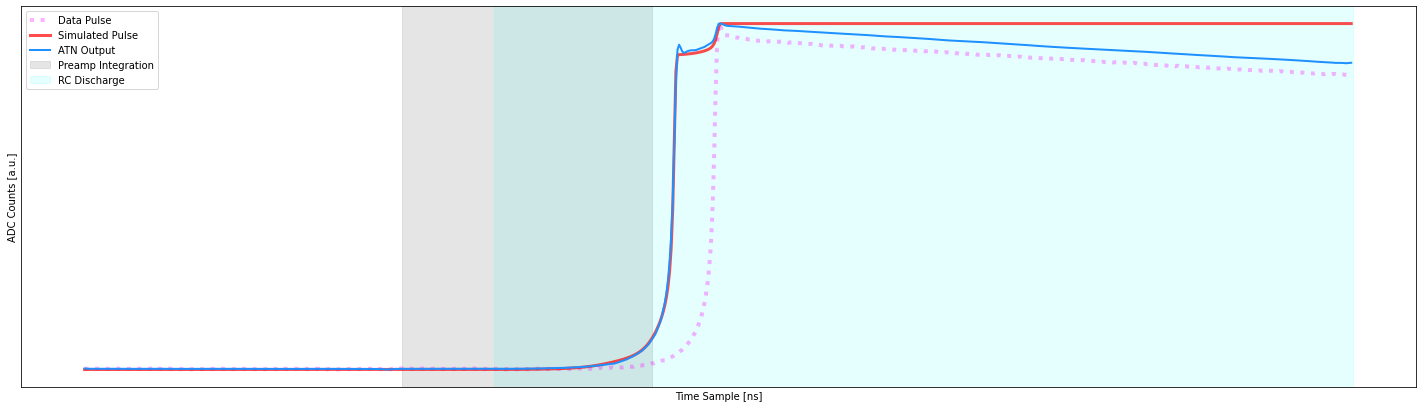

In [9]:
wf, wf_deconv, a, b = next(iter(data_dict_loader))
wf = wf.to(DEVICE)
wf_deconv = wf_deconv.to(DEVICE)
outputs  = ATN(wf_deconv)
outputs_inv = IATN(outputs)
iwf = 2 # the ith waveform in the batch to plot
detector_pulse = wf[iwf,0,:].cpu().data.numpy().flatten()
simulated_pulse = wf_deconv[iwf,0,:].cpu().data.numpy().flatten()
translated_pulse = outputs[iwf,0,:].cpu().data.numpy().flatten()
translated_pulse_inv = outputs_inv[iwf,0,:].cpu().data.numpy().flatten()
fig = plt.figure(figsize=(25, 7))
plt.plot(detector_pulse, label="Data Pulse",alpha=0.3, color="magenta", linestyle=":",linewidth = 4)
plt.plot(simulated_pulse, label="Simulated Pulse",alpha=0.7, color="red", linewidth = 3)
plt.plot(translated_pulse, label="ATN Output",color="dodgerblue", linewidth = 2)
plt.axvspan(xmin=200,xmax=358,alpha=0.2,color="grey", label="Preamp Integration")
plt.axvspan(xmin=258,xmax=800,alpha=0.1,color="cyan",label="RC Discharge")
plt.xticks([], [])
plt.yticks([], [])
plt.xlabel("Time Sample [ns]")
plt.ylabel("ADC Counts [a.u.]")
# ax_main.plot(orwf, label="Data->Siggen",alpha=0.3,color="green", linewidth = 5)
# plt.gca().get_xaxis().set_visible(False)
# plt.gca().get_yaxis().set_visible(False)
plt.legend(loc="upper left")
# plt.xlim(200, 600)
plt.savefig("figs/ATN.pdf",dpi=200)
plt.show()
plt.cla()
plt.clf()
plt.close()

- Obtain the critical reconstruction parameters of each waveform by looping through the test dataset
    - `ca`: maximal current amplitude
    - `ts`: tail slope

In [10]:
ts = []
gan_ts = []
ca = []
gan_ca = []
sim_ca = []
data_wf= []
siggen_wf= []
i=0
for wf, wf_deconv,rawwf, x in tqdm(train_loader):
    # if i==100:
    #     break
    bsize = wf.size(0)
    gan_wf = ATN(wf_deconv.to(DEVICE).float())
    for iwf in range(bsize):
        datawf = wf[iwf,0].cpu().numpy().flatten()
        siggenwf = wf_deconv[iwf,0].cpu().numpy().flatten()
        transfer_wf = gan_wf[iwf,0].detach().cpu().numpy().flatten()
        ts.append(get_tail_slope(datawf))
        gan_ts.append(get_tail_slope(transfer_wf))
        ca.append(calc_current_amplitude(datawf))
        gan_ca.append(calc_current_amplitude(transfer_wf))
        sim_ca.append(calc_current_amplitude(siggenwf))
        siggen_wf.append(siggenwf)
        data_wf.append(datawf)
        break
    i += 1


100%|██████████| 6849/6849 [01:07<00:00, 101.42it/s]


- Plotting the normalized tail slope

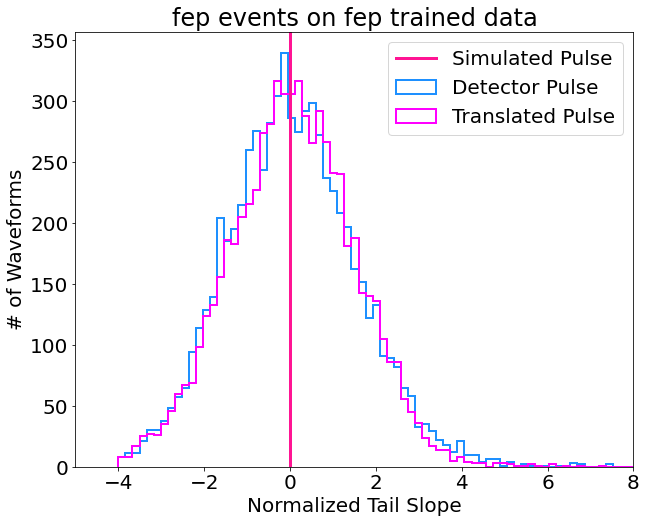

In [11]:
# Check if data is not empty after filtering and selection
if len(ts) > 0 and len(gan_ts) > 0:
    ts_quantile = select_quantile(ts)
    gan_ts_quantile = select_quantile(gan_ts)
    # Ensure selected quantile data is not empty before proceeding
    if len(ts_quantile) > 0 and len(gan_ts_quantile) > 0:
        plt.rcParams['font.size'] = 20
        plt.rcParams["figure.figsize"] = (10,8)
        mean,std = norm.fit(select_quantile(ts))
        rg = np.linspace(-4,9,80)
        plt.hist((np.array(ts)-mean)/std,bins=rg,histtype="step",linewidth=2,density=False,color="dodgerblue",label="Detector Pulse")
        mean,std= norm.fit(select_quantile(gan_ts))
        plt.hist((np.array(gan_ts)-mean)/std,bins=rg,histtype="step",linewidth=2,density=False,color="magenta",label="Translated Pulse")
        plt.axvline(x=0,color="deeppink",linewidth=3,label="Simulated Pulse")
        plt.xlim(-5,8)
        plt.legend()
        plt.title(f"{eng_peak} events on {eng_peak} trained data")
        plt.ylabel("# of Waveforms")
        plt.xlabel("Normalized Tail Slope")
        # plt.savefig("figs/tailslope.pdf",dpi=200)
    else:
        print("Quantile selected data is empty or invalid.")
else:
    print("Data is empty or contains only NaN values after filtering.")


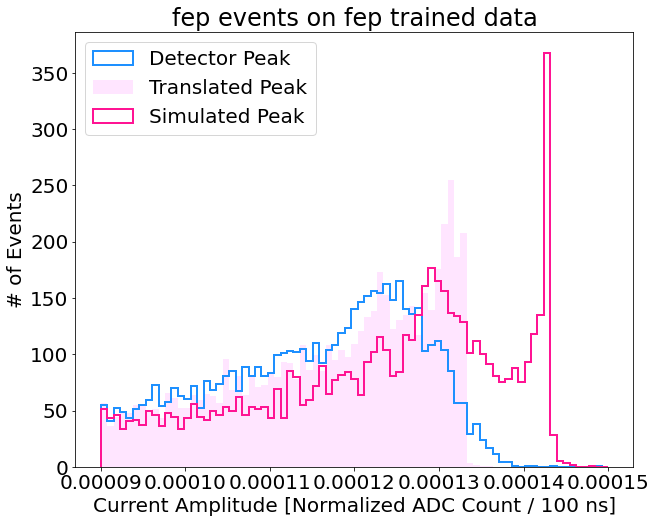

In [12]:
plt.rcParams['font.size'] = 20
plt.rcParams["figure.figsize"] = (10,8)
# rg = np.linspace(0.000125, 0.00015, 50)
rg = np.linspace(0.00009, 0.00015, 80)
# rg=200
plt.hist(ca,label="Detector Peak",bins=rg, histtype="step",linewidth=2,color="dodgerblue")
plt.hist(gan_ca,label="Translated Peak",bins=rg,alpha=0.1,color="magenta")
plt.hist(sim_ca,label="Simulated Peak",bins=rg,linewidth=2,histtype="step",color="deeppink")
plt.xlabel("Current Amplitude [Normalized ADC Count / 100 ns]")
plt.ylabel("# of Events")
plt.title(f"{eng_peak} events on {eng_peak} trained data")
plt.legend(loc="upper left")
# plt.axvline(x = 0.0843)
# plt.yscale("log")
# plt.savefig("figs/dep_current_amp.pdf",dpi=200)

- Plotting the maximal current amplitude

In [13]:
# #Code below to perform background subtraction on the histograms

# rg = np.linspace(0.065, 0.105, 200)
# bin_width = rg[1] - rg[0]  # Width of each bin

# # Compute histograms for data and background
# hist_ca, _ = np.histogram(ca, bins=rg)
# hist_gan_ca, _ = np.histogram(gan_ca, bins=rg)
# hist_sim_ca, _ = np.histogram(sim_ca, bins=rg)
# hist_background_ca, _ = np.histogram(background_ca, bins=rg)
# hist_background_sim_ca, _ = np.histogram(background_sim_ca, bins=rg)
# hist_background_atn_ca, _ = np.histogram(background_atn_ca, bins=rg)

# # Background subtraction
# hist_ca_subtracted = hist_ca - hist_background_ca
# hist_sim_ca_subtracted = hist_sim_ca - hist_background_sim_ca
# hist_sim_atn_ca_subtracted = hist_gan_ca- hist_background_atn_ca
# # hist_ca_subtracted= hist_ca_subtracted[hist_ca_subtracted>0]
# # Plotting
# plt.rcParams['font.size'] = 20
# plt.rcParams["figure.figsize"] = (10, 8)

# # Plot subtracted histograms
# # plt.hist(ca,label="DEP-",bins=rg, histtype="step",linewidth=2,color="dodgerblue")
# # plt.hist(background_ca,bins=rg,label="DEP sideband subtracted",linewidth=2,histtype="step",color="purple")
 
# plt.hist(rg[:-1], bins=rg, weights=hist_ca_subtracted, label="DEP peak", histtype="step", linewidth=2, color="dodgerblue")
# plt.hist(rg[:-1], bins=rg, weights=hist_sim_ca_subtracted, label="Sim peak", histtype="step", linewidth=2, color="deeppink")
# plt.hist(rg[:-1], bins=rg, weights=hist_sim_atn_ca_subtracted, label="ATN peak", histtype="step", linewidth=2, color="green")

# # Plot original histograms for comparison
# # plt.hist(gan_ca, label="ATN Output Pulse", bins=rg, alpha=0.1, color="magenta")
# # plt.hist(background_ca, bins=rg, label="Data Background", linewidth=2, histtype="step", color="purple")
# # plt.hist(background_sim_ca, bins=rg, label="Sim Background", linewidth=2, histtype="step", color="green")

# plt.xlabel("Current Amplitude [Normalized ADC Count / 100 ns]")
# plt.ylabel(f"# of Events / {bin_width:.3f} Current Amplitude")
# plt.title("Sideband subtracted events on FEP trained data")
# plt.legend(loc="upper left")
# # plt.axvline(x = 0.0843)
# # plt.yscale("log")
# plt.savefig("figs/dep_current_amp_comp.pdf", dpi=200)

In [14]:
# #Code to plot the survival fractions
# import numpy as np
# import matplotlib.pyplot as plt

# # Define thresholds
# thresholds = np.linspace(min(min(ca), min(gan_ca), min(sim_ca)), max(max(ca), max(gan_ca), max(sim_ca)), 100)

# # Calculate survival fractions
# survival_ca = [np.mean(ca >= thresh) for thresh in thresholds]
# survival_gan_ca = [np.mean(gan_ca >= thresh) for thresh in thresholds]
# survival_sim_ca = [np.mean(sim_ca >= thresh) for thresh in thresholds]

# # Plotting
# plt.figure(figsize=(10, 6))
# plt.plot(thresholds, survival_ca, label='Detector Pulse', color="dodgerblue")
# plt.plot(thresholds, survival_gan_ca, label='ATN Output Pulse',color="magenta")
# plt.plot(thresholds, survival_sim_ca, label='G4 Simulated Pulse',color="deeppink")

# plt.xlabel('Threshold Value')
# plt.ylabel('Survival Fraction')
# plt.title('DEP Survival Fraction')
# plt.legend()
# plt.savefig("figs/dep_survivar_frac.pdf",dpi=200)

##### 